# Introduction

Recurrent Neural Network (RNN), Long short-term Memory (LSTM) and Gated Recurrent neural networks in particular, have been firmly established as a state of the art approaches in sequence modeling and transduction problems such as language modeling and machine translation. Numerous efforts have since continued to push the boundaries of recurrent language models and encoder-decoder architectures.

Recurrent models typically factor computation along the symbol positions of the input and output sequences. Aligning the positions to steps in computation time, they generate a sequence of hidden states $h_t$, as a function of previous hidden states $h_{(t-1)}$ and the input for position $t$. This inherently sequential nature precludes parallelization within training examples, which becomes critical at longer sequence lengths, as memory constraints limit batching across examples. Recent work (`circa Dec 2017`) has achieved significant improvements in computational efficiency through factorization tricks and conditional computation, while also improving model performce in the case of the latter. The fundamental constraint of sequential computation, however, remains.

Attention mechanisms have become an integral part of the compelling sequence modeling and transduction models in various tasks, allowing for modeling of dependencies without regard to their distance in the input or output sequences. In all but a few cases, however, such attention mechanisms are used in conjunction with a recurrent network.

In the `Attention is all you need` paper, the authors propose the **Transformer**, a model architecture eschewing recurrence and instead relying entirely on an attention mechanism to draw global dependencies between the input and output. The Transformer allows for significantly more parallelization and can reach a new SOTA in translation quality after being trained for as little as twelve hours on eigth P100 GPUs.


# Background

The goal of reducing sequential computation also forms the foundation of the extended neural GPU, ByteNet, and ConvS2S, all of which use convolutational neural networks (CNN) as a basic building block, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grow in more difficult to learn dependencies between distant positions. In the Transformer, this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect the authors counteract with Multi-Head Attention.

> What is self-attention?

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representative of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representation.

End-to-end memory networks are based on recurrent attention mechanism istead of sequence aligned recurrence and have been shown to perform well on simple-langauage question answering and language modeling tasks.

**Transformer** is the first transduction model relying entirely on self-attention to compute representations of the input and output without using sequence-aligned RNNs or convoluation neural networks (CNNs)

> What is transduction?

Transduction or transductive learning is used in the field of statistical learning theory to refer to predicting specific examples given specific examples from a domain. It is contrasted with other types of learning, such as inductive learning and deductive learning

> What are challenges with RNN and advantages of transformers?

There are some challenges with RNNs:
- Long range dependencies
- Gradient Vanishing and Explosion
- Large # of training steps
- Recurrence prevents effective parallel computation

Transformers overcome these challenges:
- Facilitate long range dependencies
- No Gradient vanishing and explosion
- Fewer training steps
- No recurrence that facilitate parallel computation


# Model Architecture
Most competitive neural sequence transduction models have an encoder-decoder structure. Here, the encoder maps an input sequence of symbol representations $(x_1, x_2, ..., x_n)$ to a sequence of continuous representations $z = (z_1, z_2, ..., z_n)$. Given $z$, the decoder then generates an output sequence $(y_1, y_2, ..., y_n)$ of symbols one element at a time.  At each step the model is auto-regressive, consuming the previous generated symbols as additional inputs when generating the next. The vectors all have dimension $k$


The transformer  follows this architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the picture below:

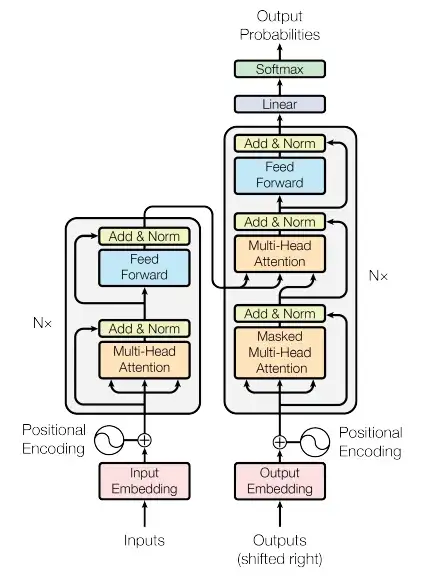

> What is the transformer?

The Transformer model extract features for each token (word or bigram) using a self-attention mechanism to figure out how important all the other words in the sentence are w.r.t to the aforementioned word. No recurrent units are used to obtain the features, and as they are just weighted sums and activations, so they can be very parallelizable and efficient.

The encoder model on the left side and the decoder is on the right one. Both contains a core block of "an attention and feed-forward network" repeated N times. 

## Encoder and Decoder Stacks
**Encoder:** The encoder is comprised of a stack of $N = 6$ identical layers. Each layer has two sub-layers. The first is a multi-head self-attention (MHSA) mechanism, and the second is a simple position-wise feed-forward network. Transformers employ a residual connection across each of the two sub-layers, followed by layer normalization. That is, the output of each sub-layer is `LayerNorm(`$x$`+ Sublayer(`$x$`))`, where `Sublayer(x)` is the function implemented by the sub-layer itself. To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension $d_{model} = 512$

**Decoder:** The decoder is also compose of a stack of $N = 6$ identical layers. In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around of the sub-layers, followed by layer normalization. We also modify the self-attention sub-layer to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the preductions for position $i$ can depende only on the known outputs at positions less than $i$

In [16]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# Input Embeddings
Let's start with input embeddings. In the context of natural language tasks, tokenization refers to how a piece of text such as 
"Attention is all you need" is represented as a sequence of vocabulary elements (called tokens)

There are several types of tokenization:
1. Character-level Tokenization
2. Word-level Tokenization
3. Subword-level Tokenization



In [17]:
# Simple character-level tokenization with small code books
import string
vocab = string.whitespace + string.ascii_letters + string.digits + string.punctuation
vocab_size = len(vocab)
print("vocab size:",vocab_size)

# create a mapping of vocab to integers
vtoi = { ch:i for i,ch in enumerate(vocab)}
itov = { i:ch for i,ch in enumerate(vocab)}
# encode takes a vocab vector and returns a list of integer tokens
encode = lambda v: [vtoi[ch] for ch in v]
# decode takes a token vector and returns a list of vocab characters
decode = lambda t: [itov[i] for i in t] 

text = "Attention is all you need"
text_enc =  encode(text)
text_dec = decode(text_enc)
print("encode:", text_enc)
print("decode:", ''.join(text_dec))

vocab size: 100
encode: [32, 25, 25, 10, 19, 25, 14, 20, 19, 0, 14, 24, 0, 6, 17, 17, 0, 30, 20, 26, 0, 19, 10, 10, 9]
decode: Attention is all you need


In [35]:
# Simple sub-word level tokenization
import tiktoken
enc = tiktoken.get_encoding('gpt2')
print("Vocab size:", enc.n_vocab)

text = "Attention is all you need"
text_enc =  enc.encode(text)
text_dec = enc.decode(text_enc)
print("encode:", text_enc)
print("decode:", text_dec)


Vocab size: 50257
encode: [8086, 1463, 318, 477, 345, 761]
decode: Attention is all you need


In [36]:
import urllib.request
import io
import sentencepiece as spm

# Loads model from URL as iterator and stores the model to BytesIO.
model = io.BytesIO()
with urllib.request.urlopen(
    'https://raw.githubusercontent.com/google/sentencepiece/master/data/botchan.txt'
) as response:
  spm.SentencePieceTrainer.train(
      sentence_iterator=response, model_writer=model, vocab_size=1000)

# Directly load the model from serialized model.
sp = spm.SentencePieceProcessor(model_proto=model.getvalue())
print(sp.encode(text))
print(sp.decode(sp.encode(text)))

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input_format: 
  model_prefix: 
  model_type: UNIGRAM
  vocab_size: 1000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy: 0
  differential_privacy_noise_level: 0
  differential_privacy_clipping_threshold: 0
}
normalizer_

[102, 14, 225, 292, 46, 89, 48, 652]
Attention is all you need


trainer_interface.cc(422) LOG(INFO) Adding meta_piece: <s>
trainer_interface.cc(422) LOG(INFO) Adding meta_piece: </s>
trainer_interface.cc(427) LOG(INFO) Normalizing sentences...
trainer_interface.cc(536) LOG(INFO) all chars count=274252
trainer_interface.cc(547) LOG(INFO) Done: 99.957% characters are covered.
trainer_interface.cc(557) LOG(INFO) Alphabet size=69
trainer_interface.cc(558) LOG(INFO) Final character coverage=0.99957
trainer_interface.cc(590) LOG(INFO) Done! preprocessed 4288 sentences.
unigram_model_trainer.cc(146) LOG(INFO) Making suffix array...
unigram_model_trainer.cc(150) LOG(INFO) Extracting frequent sub strings...
unigram_model_trainer.cc(201) LOG(INFO) Initialized 16112 seed sentencepieces
trainer_interface.cc(596) LOG(INFO) Tokenizing input sentences with whitespace: 4288
trainer_interface.cc(607) LOG(INFO) Done! 9165
unigram_model_trainer.cc(491) LOG(INFO) Using 9165 sentences for EM training
unigram_model_trainer.cc(507) LOG(INFO) EM sub_iter=0 size=5926 obj=1

In [49]:
# Let's construct the simplest transformer model meant for visualization only
block_size = 4 # maximum content length for prediction
n_embd = 5 # number of embedding tokens
batch_size = 2 # number of batches processed per pass

# We need two embedding tables - one for token with length of vocab_size, and another
# for the position embedding with length of block_size. We also need to specify how many
# embedding tokens to use for each embedding operation represented as n_embd
token_embedding_table = nn.Embedding(vocab_size, n_embd)
position_embedding_table = nn.Embedding(block_size, n_embd)
print("token embedding table shape:", token_embedding_table)
print("position embedding table shape:", position_embedding_table)

text = "Attention is all you need"
text_enc =  encode(text)
text_dec = decode(text_enc)
data = torch.LongTensor(text_enc)

sample_text = text[-block_size:]
sample_tensor = torch.LongTensor(text_enc)
print("Sample Tensor: ", sample_tensor.shape)
sample_tokens = token_embedding_table(sample_tensor)
print(f"Token for \"{sample_text}\" is {sample_tokens.shape}")
for ch, n in zip(sample_text, sample_tokens):
    print(f'"{ch}"->{n}')

token embedding table shape: Embedding(100, 5)
position embedding table shape: Embedding(4, 5)
Sample Tensor:  torch.Size([25])
Token for "need" is torch.Size([25, 5])
"n"->tensor([-0.0289,  0.0166,  0.1041,  1.3764, -0.0680],
       grad_fn=<UnbindBackward0>)
"e"->tensor([-0.1686, -0.3767,  1.2521, -0.4655,  1.5502],
       grad_fn=<UnbindBackward0>)
"e"->tensor([-0.1686, -0.3767,  1.2521, -0.4655,  1.5502],
       grad_fn=<UnbindBackward0>)
"d"->tensor([ 0.6521, -2.5698,  0.0976,  1.0283, -1.0898],
       grad_fn=<UnbindBackward0>)


In [53]:

def get_batch():
    ix = torch.randint(0, len(text_enc)-block_size-1, (block_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    print(f'x=\n{x}\ny=\n{y}\n')
    return x,y

x, y = get_batch()
print(x.shape, y.shape)

x=
tensor([[30, 20, 26,  0],
        [ 0, 30, 20, 26],
        [25, 10, 19, 25],
        [ 0,  6, 17, 17]])
y=
tensor([[20, 26,  0, 19],
        [30, 20, 26,  0],
        [10, 19, 25, 14],
        [ 6, 17, 17,  0]])

torch.Size([4, 4]) torch.Size([4, 4])
